In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from causalml.dataset import synthetic_data
from sklearn.model_selection import KFold

ModuleNotFoundError: No module named 'causalml'

In [2]:
from importlib import reload
import causal_inference.propensity as causal

reload(causal)

ModuleNotFoundError: No module named 'causal_inference'

In [4]:
def calculate_ate(ite):
    return ite.mean().round(2), ite.std().round(2)

def calculate_propensity(propensity):
    return propensity.mean().round(2), propensity.std().round(2)

In [5]:

y, X, treatment, true_ite, expected_outcome, true_propensity = synthetic_data(mode=1,
                                                                              n=1000,
                                                                              p=10,
                                                                              sigma=2)

# As the mean propensity doesn't say lot it would be nice to plot the true propensity to see the overlap between
# control and treated.
# It should be done like: http://ethen8181.github.io/machine-learning/ab_tests/causal_inference/matching.html

print("The true ATE of the generated data is",
      calculate_ate(true_ite)[0],
      "with standard deviation equal to",
      calculate_ate(true_ite)[1],
      ".")

print("The average propensity score value is equal to",
      calculate_propensity(true_propensity)[0],
      "with standard deviation equal to",
      calculate_propensity(true_propensity)[1],
      ".")


The true ATE of the generated data is 0.5 with standard deviation equal to 0.2 .
The average propensity score value is equal to 0.52 with standard deviation equal to 0.3 .


In [40]:
# Make a df from it

df = pd.DataFrame(X, columns = ['x' + str(i) for i in range(X.shape[1])])
df['treatment'] = treatment
df['outcome'] = y

df.head()


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,treatment,outcome
0,0.359627,0.446570,0.411718,0.649406,0.639417,0.382112,0.064756,0.707055,0.672825,0.838403,0,-0.019813
1,0.662416,0.741412,0.726182,0.172345,0.306480,0.789330,0.207179,0.417174,0.594880,0.462731,1,2.903387
2,0.278708,0.886643,0.231053,0.710887,0.979224,0.238260,0.227481,0.816783,0.554203,0.249234,0,-0.848033
3,0.028814,0.650119,0.676624,0.108490,0.553162,0.215532,0.515815,0.595005,0.132184,0.857128,0,1.580476
4,0.009053,0.686230,0.339981,0.380432,0.320762,0.841956,0.492759,0.939890,0.030171,0.664879,1,1.744999


In [42]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline


<AxesSubplot:xlabel='outcome', ylabel='Density'>

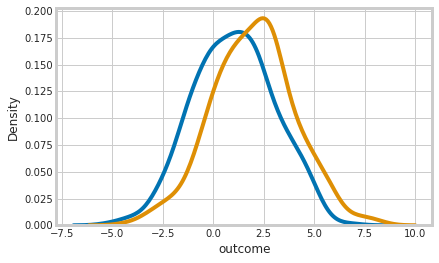

In [45]:

sns.kdeplot(df[df.treatment == 0]['outcome'], label="untreated")
sns.kdeplot(df[df.treatment == 1]['outcome'], label="untreated")

In [50]:
print("The true ATE of the generated data is equal to",
      calculate_ate(true_ite)[0],".")
print("Estimated ATE is equal to",
      calculate_ate(df[df.treatment == 1]['outcome'])[0] - calculate_ate(df[df.treatment == 0]['outcome'])[0],".")


The true ATE of the generated data is equal to 0.5 .
Estimated ATE is equal to 0.97 .


In [73]:
from scipy.stats import wasserstein_distance
from scipy import stats

def calc_ndiff(covariate_control, covariate_treated):
    m_c = covariate_control.mean()
    m_t = covariate_treated.mean()
    std_c = covariate_control.std()
    std_t = covariate_treated.std()
    ndiff = (m_t-m_c) / np.sqrt((std_c**2+std_t**2)/2)
    return ndiff

In [ ]:
df_summary = pd.DataFrame(index = df.iloc[:,0:X.shape[1]].columns.to_list())

In [90]:
for i in range(X.shape[1]):
    covariate_control = df[df.treatment == 0].iloc[:,i]
    covariate_treated = df[df.treatment == 1].iloc[:,i]
    df_summary.iloc[i,:]['norm-diff'] = calc_ndiff(covariate_control, covariate_treated)
    print(wasserstein_distance(covariate_control,covariate_treated))
    # If p-value is low then we can reject the null hypothesis that
    # the distributions of the two samples are the same
    print(stats.ks_2samp(covariate_control,covariate_treated)[1])

0.1855265068932163
1.1761494485390301e-24
0.22090652730320823
7.130816475994311e-30
0.02028992444022526
0.4941477600215872
0.01869125043627079
0.16577477732698975
0.019758143174014364
0.3657831498468527
0.017070076455082468
0.7095358643224496
0.01593028429128746
0.6353165825427982
0.02888277238889737
0.27954791900018694
0.013197820776808289
0.8053964166070375
0.04308167291423168
0.031059804471000985


In [126]:
# Similiar way to do the below, probably better. Check this. Goal Gio: prepare Table 1 on COVID data.

# http://ethen8181.github.io/machine-learning/ab_tests/causal_inference/matching.html

In [130]:
norm_diff, w_dist, ks_test = [], [], []

# make it an iteration over the methods
# maybe it should be a more pythonic way to do it but less clear?

for index, row in df_summary.iterrows():
    idx = int(index[1])
    covariate_control = df[df.treatment == 0].iloc[:,idx]
    covariate_treated = df[df.treatment == 1].iloc[:,idx]
    norm_diff.append(calc_ndiff(covariate_control, covariate_treated).round(2))
    w_dist.append(wasserstein_distance(covariate_control,covariate_treated).round(2))
    ks_test.append(stats.ks_2samp(covariate_control,covariate_treated)[1].round(3))

df_summary['norm_dist'] = norm_diff
df_summary['w_dist'] = w_dist
df_summary['ks_test'] = ks_test
df_summary

,norm_dist,w_dist,ks_test
x0,0.69,0.19,0.000
x1,0.82,0.22,0.000
x2,-0.07,0.02,0.494
x3,0.06,0.02,0.166
x4,-0.05,0.02,0.366
x5,-0.05,0.02,0.710
x6,0.01,0.02,0.635
x7,-0.09,0.03,0.280
x8,0.04,0.01,0.805
x9,0.15,0.04,0.031


In [ ]:
# can we the same tests on a weighted sample?

In [132]:
#First analyze the propensity

df['p_score'] = true_propensity
p_score_control = df[df.treatment == 0]['p_score']
p_score_treated = df[df.treatment == 1]['p_score']
print('treatment count:', p_score_control.shape)
print('control count:', p_score_treated.shape)

treatment count: (493,)
control count: (507,)


In [135]:
# Kind of implements matching

# http://ethen8181.github.io/machine-learning/ab_tests/causal_inference/matching.html

In [ ]:
# statistical tests http://benalexkeen.com/comparative-statistics-in-python-using-scipy/

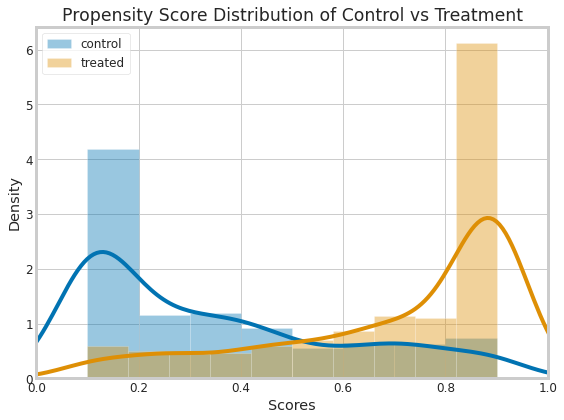

In [133]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(p_score_control, label='control')
sns.distplot(p_score_treated, label='treated')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
X_new = np.hstack((X, treatment.reshape(len(treatment), 1)))

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_new, y,
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)


In [7]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()



In [8]:
my_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('estimate_propensity', causal.PropensityEstimator()),
    ('model', model)
])

In [10]:
from sklearn.metrics import mean_squared_error

# Preprocessing of training data, fit model
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_squared_error(y_valid, preds)
print('MSE:', score)

The propensity score was estimated using a logistic regression model with accuracy 0.745
The balance of the covariate distribution is ?
The propensity score was estimated using a logistic regression model with accuracy 0.76
The balance of the covariate distribution is ?
MSE: 4.006032626557897


In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# define the model cross-validation configuration

cv = KFold(n_splits=10)

# evaluate the pipeline using cross validation and calculate MAE
scores = cross_val_score(my_pipeline,
                         X_train, y_train,
                         scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

# convert MAE scores to positive values
scores
# summarize the model performance
print('MSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

MSE: -4.367 (0.573)


In [23]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(my_pipeline, X_new, y, cv=5,
                         scoring = 'neg_mean_squared_error')
scores

ValueError: For evaluating multiple scores, use sklearn.model_selection.cross_validate instead. ['neg_mean_squared_error', 'r2'] was passed.

In [18]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy: -4.22 (+/- 0.86)


In [26]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

scoring = ['neg_mean_squared_error', 'r2']

scores = cross_validate(model, X_new, y, scoring=scoring)

sorted(scores.keys())

['fit_time', 'score_time', 'test_neg_mean_squared_error', 'test_r2']

In [27]:
scores['fit_time']

array([0.00266266, 0.0013814 , 0.00135016, 0.00140071, 0.00277019])

In [ ]:
from sklearn.metrics import make_scorer
scoring = {'prec_macro': 'precision_macro',
           'rec_macro': make_scorer(recall_score, average='macro')}

scores = cross_validate(model, X, y, scoring=scoring,
                        cv=5, return_train_score=True)

sorted(scores.keys())
scores['train_rec_macro']

In [13]:
# What is the godness of fit metric?
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [15]:
distances[1]

array([0.        , 0.43294188])

In [17]:
indices[731]

array([731,   1])

In [18]:
indices.reshape(-1,1).shape

(2000, 1)